In [99]:
from sunbird.data.data_utils import convert_to_summary
from pathlib import Path
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')


def summary_coords(statistic):
    return {
        'statistics': ['quantile_data_correlation', 'quantile_correlation'],
        'quantiles': [0, 1, 3, 4],
        'multipoles': [0, 2],
        's': s,
    }

def lhc_fnames(statistic):
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/dsc_conf/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    return Path(data_dir) / f'{statistic}_lhc.npy'

def read_lhc(statistic='dsc_conf', return_sep=False):
    data_fn = lhc_fnames(statistic)
    data = np.load(data_fn, allow_pickle=True).item()
    lhc_x = data['lhc_x']
    lhc_x_names = data['lhc_x_names']
    coords = summary_coords(statistic)
    dimensions = list(coords.keys())
    dimensions.insert(0, 'mock_idx')
    coords['mock_idx'] = np.arange(data['lhc_y'].shape[0])
    lhc_y = data['lhc_y'].reshape([len(coords[d]) for d in dimensions])
    lhc_y = convert_to_summary(data=lhc_y, dimensions=dimensions, coords=coords)
    return lhc_x, lhc_y, lhc_x_names

def read_covariance():
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/dsc_conf/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    data_fn = Path(data_dir) / f'dsc_conf_lhc.npy'
    y = np.load(data_fn, allow_pickle=True).item()['cov_y']
    prefactor = 1 / 64
    cov = prefactor * np.cov(y, rowvar=False)
    corr = np.corrcoef(y, rowvar=False)
    return cov, corr

covariance_matrix, correlation_matrix = read_covariance()
lhc_x, lhc_y, lhc_x_names = read_lhc(return_sep=True)
print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')
print(f'Loaded covariance with shape: {covariance_matrix.shape}')



Loaded LHC with shape: (8500, 20), (8500, 2, 4, 2, 38)
Loaded covariance with shape: (608, 608)


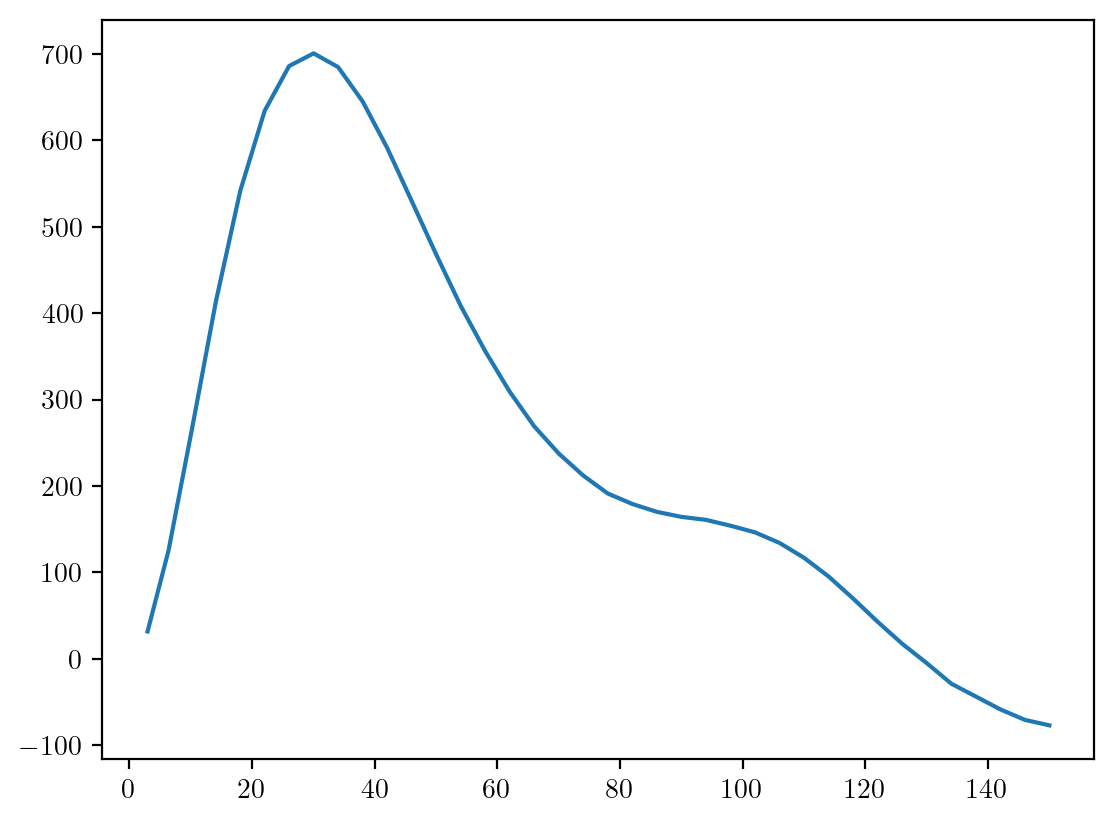

In [135]:
mask = lhc_y.where(lhc_y.multipoles.isin([0]) &
                   lhc_y.quantiles.isin([0]) &
                   lhc_y.statistics.isin(['quantile_correlation'])
).to_masked_array().mask

y = lhc_y.values[~mask].reshape(lhc_y.shape[0], -1)

fig, ax = plt.subplots()
ax.plot(lhc_y.s, lhc_y.s**2*y[466])
plt.show()

In [169]:
# asd = [getattr(getattr(lhc_y, 'multipoles'), 'isin')([0]),
#        getattr(getattr(lhc_y, 'quantiles'), 'isin')([0]),
#        getattr(getattr(lhc_y, 'statistics'), 'isin')(['quantile_correlation'])]

filters = {
    'multipoles': [0]
}

asd = [getattr(getattr(lhc_y, key), 'isin')(value) for key, value in filters.items()]

# [asd[i] & asd[i+1] for i in range(len(asd) - 1)]

for i, el in enumerate(asd):
    op = op & el if i > 0 else asd[0]
    
lhc_y.where(op).to_masked_array().mask.shape

(8500, 2, 4, 2, 38)

In [113]:
list(lhc_y.values).index(lhc_y.sel({'mock_idx':466}).values)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(4, 1, 38)


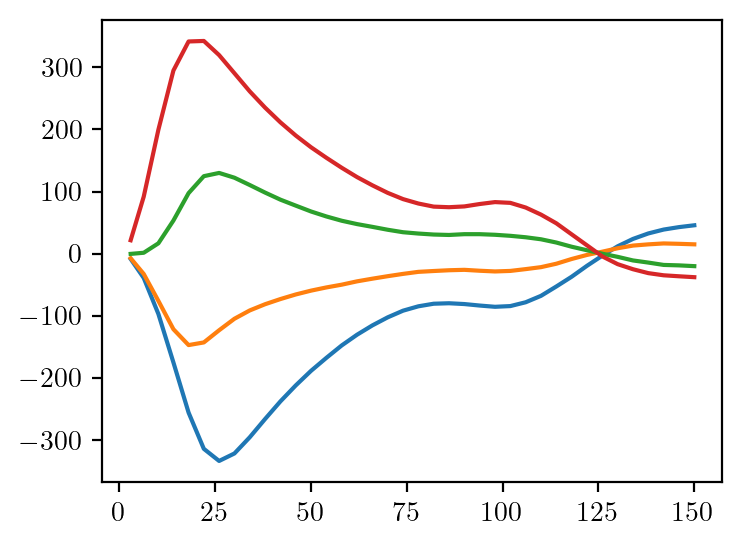

In [41]:
x = summary.s
y = summary.sel({'hod_idx':466, 'multipoles':[0], 'statistics':'quantile_data_correlation'})

print(y.shape)

fig, ax = plt.subplots(figsize=(4, 3))
for q in range(4):
    ax.plot(x, x**2*y[q])
plt.show()

In [47]:
import json

with open(f"/pscratch/sd/e/epaillas/sunbird/data/coordinates/density_split_cross.json", "r") as f:
    coords = json.load(f)
    dimensions = list(coords.keys())
    
dimensions

['quintiles', 'multipoles', 's']

In [52]:
import numpy as np
from sunbird.emulators import FCN
from pathlib import Path
from sunbird.inference.hamiltonian import HMC
from sunbird.inference.priors import Yuan23, AbacusSummit
from sunbird.data.data_utils import convert_to_summary
import torch
from astropy.stats import sigma_clip


def summary_coords(statistic, data):
    if statistic == 'dsc_conf':
        return {
            'statistics': ['quantile_data_correlation', 'quantile_correlation'],
            'quantiles': [0, 1, 3, 4],
            'multipoles': [0, 2],
            's': data['s'],
        }
    elif statistic == 'tpcf':
        return {
            'multipoles': [0, 2],
            's': data['s'],
        }
    elif statistic == 'pk':
        return {
            'multipoles': [0, 2],
            'k': data['k'],
        }
    elif statistic == 'wp':
        return {
            's': data['r_p'],
        }

def lhc_fnames(statistic):
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    return Path(data_dir) / f'{statistic}_lhc.npy'

def emulator_error_fnames(statistic):
    data_dir = f'/pscratch/sd/e/epaillas/emc/emulator_error/{statistic}/'
    return Path(data_dir) / f'{statistic}_emulator_error.npy'

def covariance_fnames(statistic):
    data_dir = f'/pscratch/sd/e/epaillas/emc/training_sets/{statistic}/cosmo+hod/z0.5/yuan23_prior/ph000/seed0/'
    return Path(data_dir) / f'{statistic}_lhc.npy'

def read_lhc(statistics, select_filters={}, slice_filters={}):
    lhc_y_all = []
    mask_all = []
    for statistic in statistics:
        data_fn = lhc_fnames(statistic)
        data = np.load(data_fn, allow_pickle=True).item()
        coords = summary_coords(statistic, data)
        lhc_x = data['lhc_x']
        lhc_x_names = data['lhc_x_names']
        lhc_y = data['lhc_y']
        if filters:
            lhc_y, mask = filter_lhc(statistic, lhc_y, coords, select_filters, slice_filters)
            mask_all.append(mask)
        lhc_y_all.append(lhc_y)
    lhc_y_all = np.concatenate(lhc_y_all, axis=1)
    return lhc_x, lhc_y_all, lhc_x_names, mask_all

def filter_lhc(statistic, lhc_y, coords, select_filters, slice_filters):
    select_filters = {key: value for key, value in select_filters.items() if key in coords}
    slice_filters = {key: value for key, value in slice_filters.items() if key in coords}
    dimensions = list(coords.keys())
    dimensions.insert(0, 'mock_idx')
    coords['mock_idx'] = np.arange(lhc_y.shape[0])
    lhc_y = lhc_y.reshape([len(coords[d]) for d in dimensions])
    lhc_y = convert_to_summary(data=lhc_y, dimensions=dimensions, coords=coords)
    select_filters = [getattr(getattr(lhc_y, key), 'isin')(value) for key, value in select_filters.items()]
    slice_filters = [(getattr(lhc_y, key) >= value[0]) & (getattr(lhc_y, key) <= value[1]) for key, value in slice_filters.items()]
    if select_filters:
        for i, cond in enumerate(select_filters):
            select_mask = select_mask & cond if i > 0 else select_filters[0]
        select_mask = lhc_y.where(select_mask).to_masked_array().mask
    else:
        select_mask = np.full(lhc_y.shape, False)
    if slice_filters:
        for i, cond in enumerate(slice_filters):
            slice_mask = slice_mask & cond if i > 0 else slice_filters[0]
        slice_mask = lhc_y.where(slice_mask).to_masked_array().mask
    else:
        slice_mask = np.full(lhc_y.shape, False)
    mask = select_mask | slice_mask
    return lhc_y.values[~mask].reshape(lhc_y.shape[0], -1), mask[0]



priors = {**AbacusSummit().prior, **Yuan23().prior}
select_filters = {'multipoles': [0, 2], 'statistics': ['quantile_data_correlation']}
slice_filters = {'s': [20, 200], 'k': }
fixed_params = ['w0_fld', 'wa_fld', 'nrun', 'N_ur',]
add_emulator_error = True
# statistics = ['wp', 'dsc_conf', 'tpcf']
statistics = ['pk']


lhc_x, lhc_y, lhc_x_names, model_filters = read_lhc(statistics=statistics, 
                                                    select_filters=select_filters,
                                                    slice_filters=slice_filters)
print(f'Loaded LHC with shape: {lhc_x.shape}, {lhc_y.shape}')

Loaded LHC with shape: (8500, 20), (8500, 158)
